# Wayang Character Classification using Ensemble Learning
This notebook demonstrates a deep learning approach to classify Indonesian Wayang characters using an ensemble of three pre-trained CNN architectures: **InceptionV3**, **EfficientNetB2**, and **ResNet101V2**.

### Workflow:
1. **ETL Process**: Extracting data, analyzing distribution, and splitting into Train/Val/Test sets.
2. **Data Augmentation**: Preparing image generators with rescaling and augmentation.
3. **Model Development**: Building and fine-tuning three different pre-trained models.
4. **Ensemble Implementation**: Combining predictions using majority voting for improved accuracy.
5. **Evaluation**: Detailed analysis of individual and ensemble performance.

---

# 1. Setup and Imports

In [2]:
import os
import kagglehub
import numpy as np
import shutil
import zipfile
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow/Keras imports
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2, InceptionV3, ResNet101V2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import plot_model

# Ignore Keras user warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

print(f"TensorFlow version: {tf.__version__}")

C:\Users\Pongo\PycharmProjects\Playground\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.18.0


# 2. ETL (Extract, Transform, Load) Process
## 2.1 Extract Data
In this step, we identify the dataset structure and analyze the distribution of images across different Wayang character classes.

In [14]:
# Download (will resolve to /kaggle/input/... in Colab)
dataset_path = kagglehub.dataset_download("achmatim/indonesian-wayang-traditional-puppet-show")

# Create your own folder
os.makedirs("data", exist_ok=True)

# Copy everything into ./data
for item in os.listdir(dataset_path):
    src = os.path.join(dataset_path, item)
    dst = os.path.join("data", item)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

print("Dataset copied to ./data")

Using Colab cache for faster access to the 'indonesian-wayang-traditional-puppet-show' dataset.
Dataset copied to ./data


In [9]:
data_dir = "data/labeled-indonesian-wayang"

# Get the list of all classes (subdirectories)
classes = sorted(os.listdir(data_dir))
print(f"Detected {len(classes)} classes:")
print(classes)

Detected 22 classes:
['abimanyu', 'anoman', 'arjuna', 'bagong', 'baladewa', 'bima', 'buta', 'cakil', 'durna', 'dursasana', 'duryudana', 'gareng', 'gatotkaca', 'karna', 'kresna', 'nakula_sadewa', 'patih_sabrang', 'petruk', 'puntadewa', 'semar', 'sengkuni', 'togog']


In [16]:
# Initialize a counter to store the number of images per class
class_counts = Counter()

# Iterate over each class directory
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of images in each class directory
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the distribution of images per class
print("Data Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Data Distribution:
abimanyu: 256 images
anoman: 352 images
arjuna: 400 images
bagong: 384 images
baladewa: 400 images
bima: 336 images
buta: 368 images
cakil: 304 images
durna: 192 images
dursasana: 288 images
duryudana: 304 images
gareng: 192 images
gatotkaca: 320 images
karna: 256 images
kresna: 368 images
nakula_sadewa: 192 images
patih_sabrang: 272 images
petruk: 320 images
puntadewa: 272 images
semar: 352 images
sengkuni: 256 images
togog: 192 images


/tmp/ipython-input-268310412.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


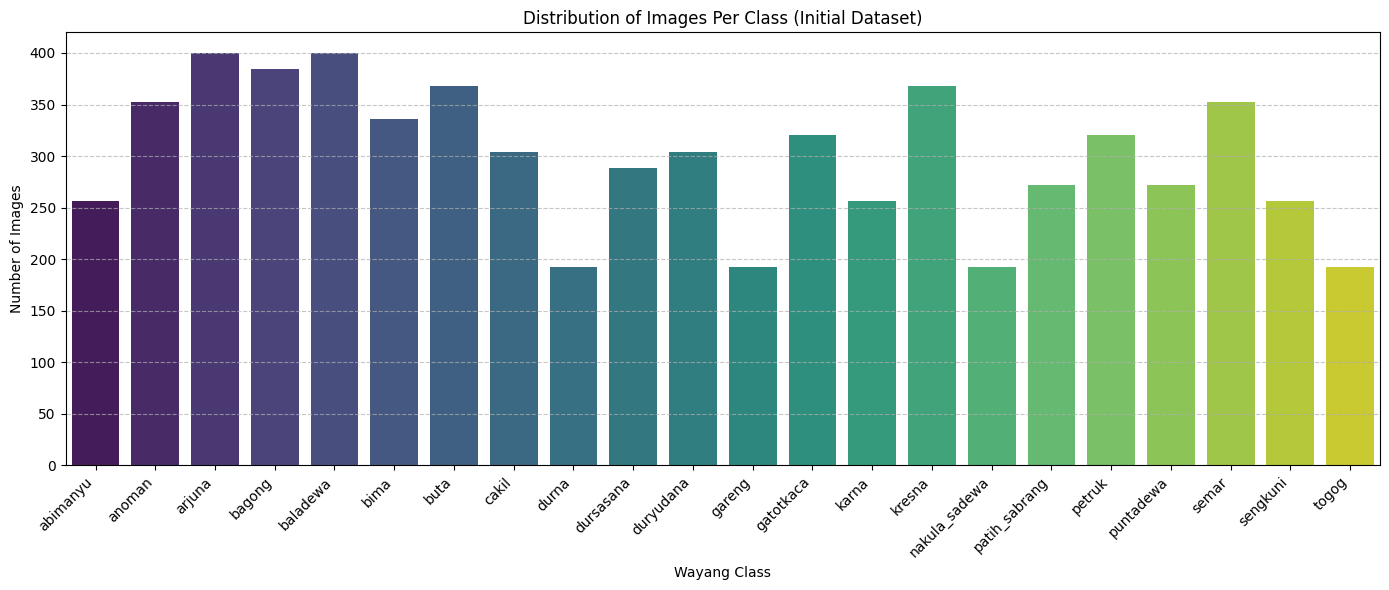

In [17]:
# Plot the distribution using a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xlabel('Wayang Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Per Class (Initial Dataset)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [18]:
# Show images extension
extensions = set()
for root, dirs, files in os.walk(data_dir):
    for file in files:
        _, ext = os.path.splitext(file)
        extensions.add(ext)

print(extensions)

{'.jpg', '.JPG'}


## 2.2 Data Splitting
We split the data into **Training (70%)**, **Validation (15%)**, and **Testing (15%)** sets to ensure the models are evaluated on unseen data.

In [7]:
# Define relative paths for split data
train_dir = 'data/train'
val_dir = 'data/validation'
test_dir = 'data/test'

In [19]:
# Create directories if they don't exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Split data into train, validation, and test sets
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Create class subdirectories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split: 70% Train, 30% Temp
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    # Split Temp: 50% Val, 50% Test (Total 15% each)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Helper to copy files
    def copy_images(image_list, src, dst):
        for img in image_list:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))

    copy_images(train_images, class_path, os.path.join(train_dir, class_name))
    copy_images(val_images, class_path, os.path.join(val_dir, class_name))
    copy_images(test_images, class_path, os.path.join(test_dir, class_name))

print("Data splitting and copying complete.")

Data splitting and copying complete.


Total training images: 4595
Total validation images: 987
Total test images: 994


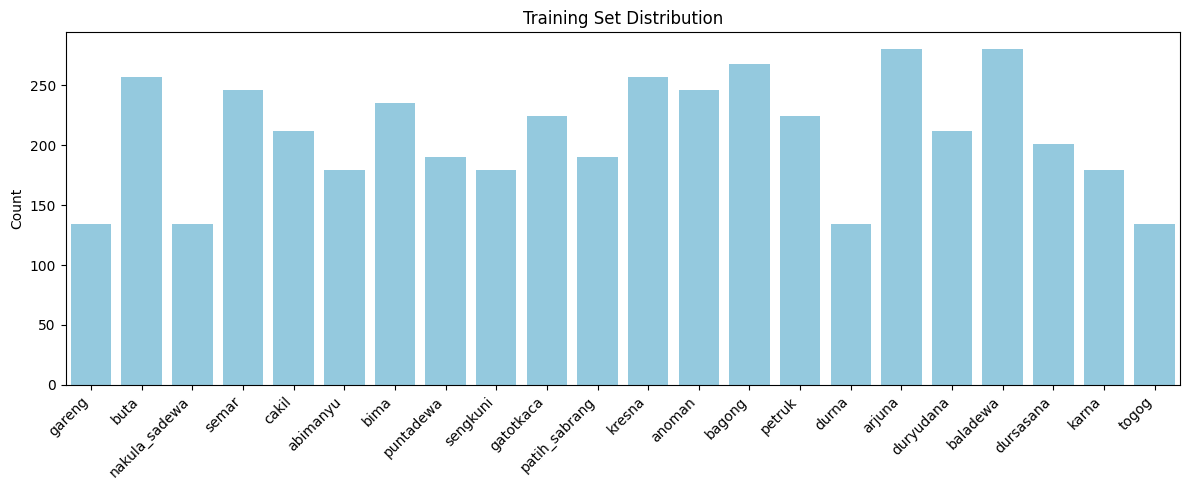

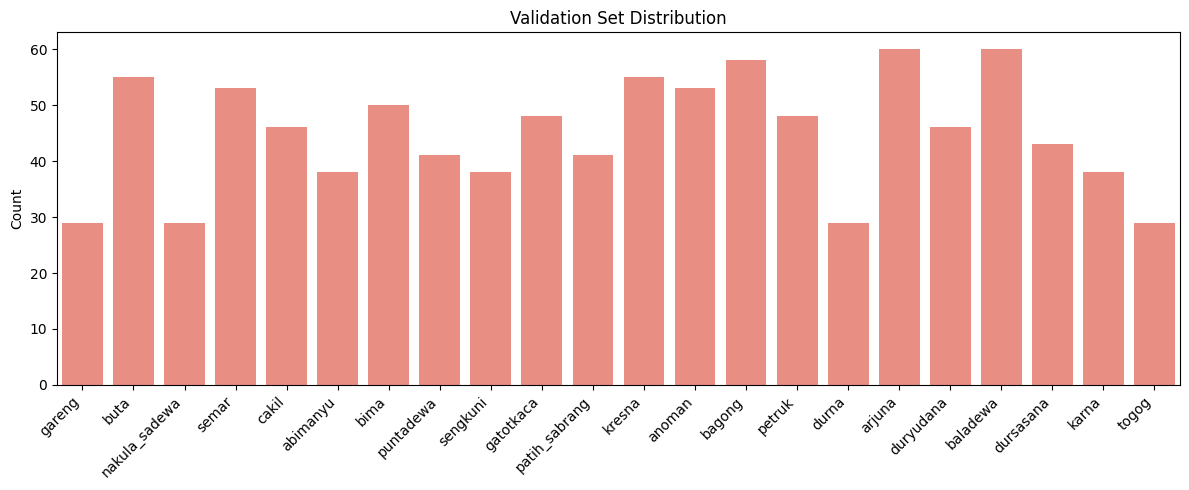

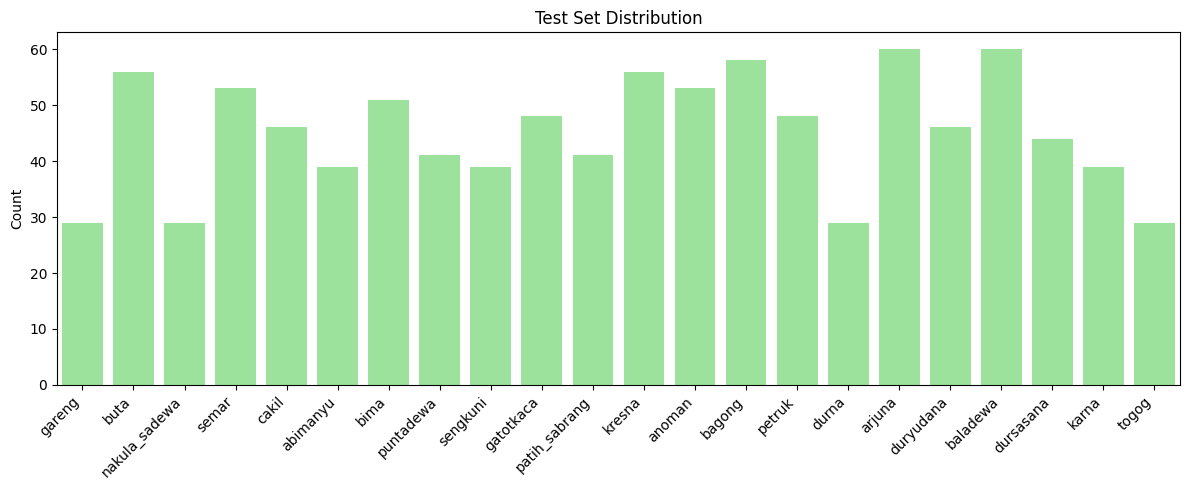

In [20]:
# Verify the number of images in each split
def get_split_counts(directory, split_name):
    counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = get_split_counts(train_dir, "Train")
val_counts = get_split_counts(val_dir, "Validation")
test_counts = get_split_counts(test_dir, "Test")

print(f"Total training images: {sum(train_counts.values())}")
print(f"Total validation images: {sum(val_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")

# Visualization of Split Distribution
def plot_split_distribution(counts, title, color):
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), color=color)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_split_distribution(train_counts, 'Training Set Distribution', 'skyblue')
plot_split_distribution(val_counts, 'Validation Set Distribution', 'salmon')
plot_split_distribution(test_counts, 'Test Set Distribution', 'lightgreen')

## 2.3 Transform & Load Data
We use `ImageDataGenerator` for normalization and real-time data augmentation. All images are resized to **224x224** to match the input requirements of our pre-trained models.

In [8]:
# Image configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Training generator with rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

# Validation and Test generator
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4595 images belonging to 22 classes.
Found 987 images belonging to 22 classes.
Found 994 images belonging to 22 classes.


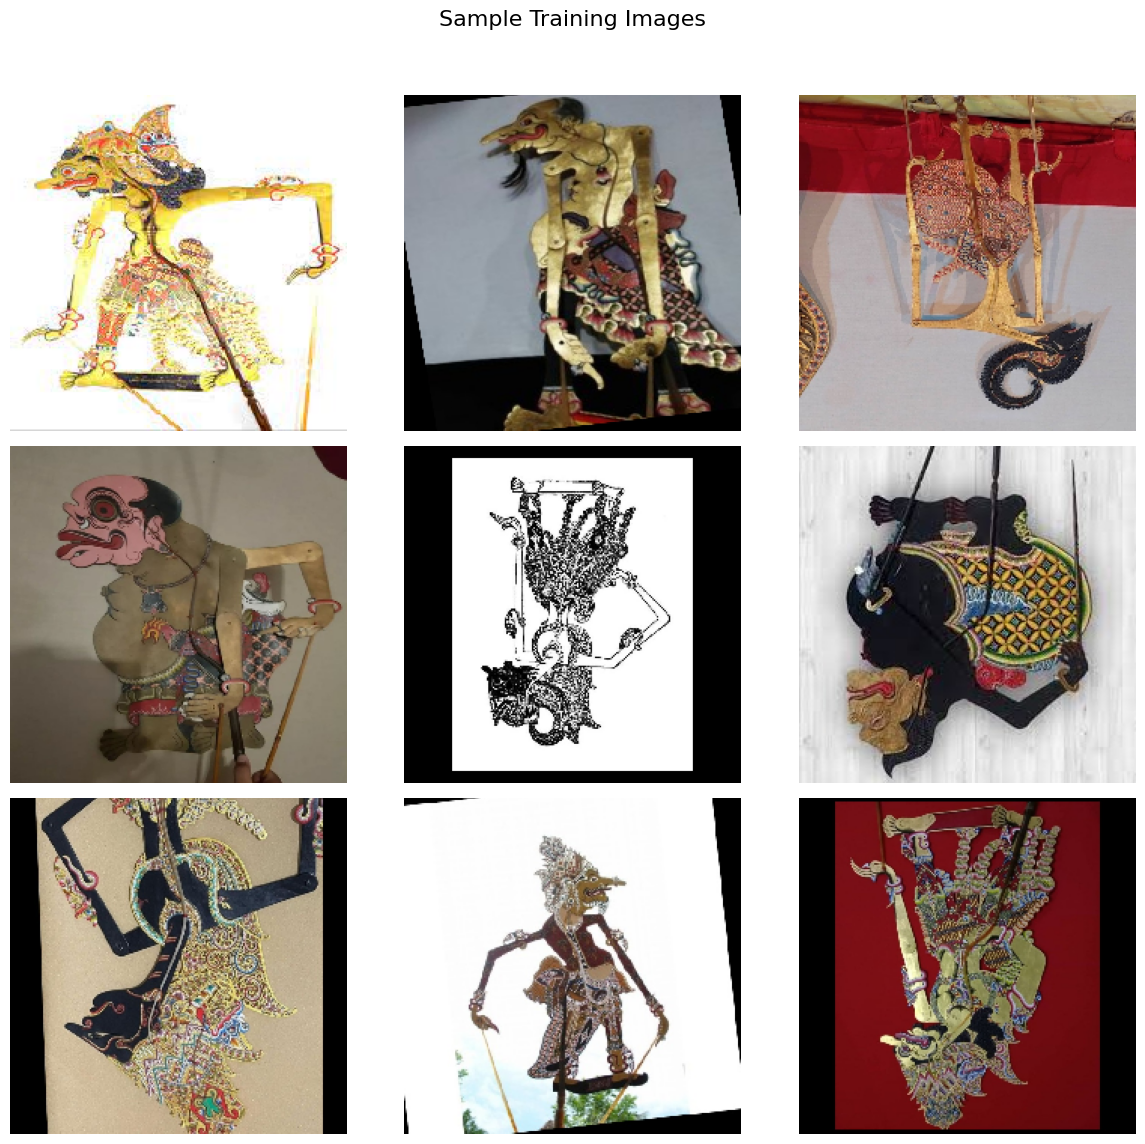

In [22]:
# Show some sample images from the training set
sample_images = next(train_generator)[0][:9]  # Get the first 9 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()
for ax, img in zip(axes, sample_images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
plt.suptitle('Sample Training Images', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

# 3. ML Model Development
We employ **Transfer Learning** using three state-of-the-art architectures. For each model:
1. We load the model with weights pre-trained on ImageNet.
2. We freeze the initial 50 layers to retain low-level feature extraction capabilities.
3. We add a custom classification head (Global Average Pooling, Dense layers, and a Softmax output).

## 3.1 Model Architecture Setup

In [23]:
def create_pretrained_model(base_model, num_classes, freeze_layers=50):
    """
    Creates a custom model by adding a classification head to a pre-trained base model.
    """
    # Freeze the first few layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Use AdamW optimizer for better weight decay handling
    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=0.005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [24]:
# Instantiate Pre-trained Base Models
input_shape = (224, 224, 3)
num_classes = len(classes)

print("Loading base models...")
inception_v3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
efficientnet_b2_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_101v2_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Create final models
models = [
    create_pretrained_model(inception_v3_base, num_classes),
    create_pretrained_model(efficientnet_b2_base, num_classes),
    create_pretrained_model(resnet_101v2_base, num_classes)
]

# Set names for easier reference
models[0]._name = "InceptionV3_Custom"
models[1]._name = "EfficientNetB2_Custom"
models[2]._name = "ResNet101V2_Custom"

for m in models:
    print(f"Model: {m.name} | Total layers: {len(m.layers)}")

Loading base models...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model: functional | Total layers: 315
Model: functional_1 | Total layers: 344
Model: functional_2 | Total layers: 381


## 3.2 Model Training
We use **Early Stopping** to prevent overfitting and **ReduceLROnPlateau** to fine-tune the learning rate when the validation loss plateaus.

In [25]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

# Training loop
histories = []
os.makedirs('models/non-augmented', exist_ok=True)

for i, model in enumerate(models):
    print(f"\nTraining Model {i+1}: {model.name}")
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    histories.append(history)

    # Save model
    save_path = f'models/non-augmented/model_{i+1}.h5'
    model.save(save_path)
    print(f"Model {i+1} saved to {save_path}")


Training Model 1: functional
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.4705 - loss: 1.8026 - val_accuracy: 0.0963 - val_loss: 5.5355 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 408ms/step - accuracy: 0.9137 - loss: 0.3088 - val_accuracy: 0.5268 - val_loss: 2.4166 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 411ms/step - accuracy: 0.9491 - loss: 0.1701 - val_accuracy: 0.5035 - val_loss: 3.5613 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.9605 - loss: 0.1342 - val_accuracy: 0.5390 - val_loss: 2.2291 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 413ms/step - accuracy: 0.9703 - loss: 0.0990 - val_accuracy: 0.5015 - val_loss: 2.8052 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 425ms/step - accuracy: 0.9713 - loss: 0.1006 - val_accuracy: 0.5988 - val_loss: 2.2164 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 466ms/step -

Model 1 saved to models/non-augmented/model_1.h5

Training Model 2: functional_1
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.3181 - loss: 2.3317 - val_accuracy: 0.0740 - val_loss: 3.0414 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.8367 - loss: 0.5220 - val_accuracy: 0.3789 - val_loss: 2.2872 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 396ms/step - accuracy: 0.9227 - loss: 0.2584 - val_accuracy: 0.4377 - val_loss: 2.0332 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.9576 - loss: 0.1451 - val_accuracy: 0.8936 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 399ms/step - accuracy: 0.9731 - loss: 0.0875 - val_accuracy: 0.9210 - val_loss: 0.2825 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.9705 - loss: 0.1066 - val_accuracy: 0.9048 - val_loss: 0.3860 - learning_rate: 0.0010
Epo

Model 2 saved to models/non-augmented/model_2.h5

Training Model 3: functional_2
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.3472 - loss: 2.1886 - val_accuracy: 0.0608 - val_loss: 163.6080 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 857ms/step - accuracy: 0.7493 - loss: 0.7854 - val_accuracy: 0.2016 - val_loss: 10.6887 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 857ms/step - accuracy: 0.9035 - loss: 0.2999 - val_accuracy: 0.4630 - val_loss: 2.4331 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 852ms/step - accuracy: 0.9372 - loss: 0.1965 - val_accuracy: 0.6616 - val_loss: 1.3055 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 855ms/step - accuracy: 0.9562 - loss: 0.1504 - val_accuracy: 0.7275 - val_loss: 1.4609 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 857ms/step - accuracy: 0.9580 - loss: 0.1427 - val_accuracy: 0.5623 - val_loss: 2.7991 - learning_rate: 0.0010


Model 3 saved to models/non-augmented/model_3.h5


## 3.3 Training History Visualization
We plot the accuracy and loss curves for all models to analyze their convergence.

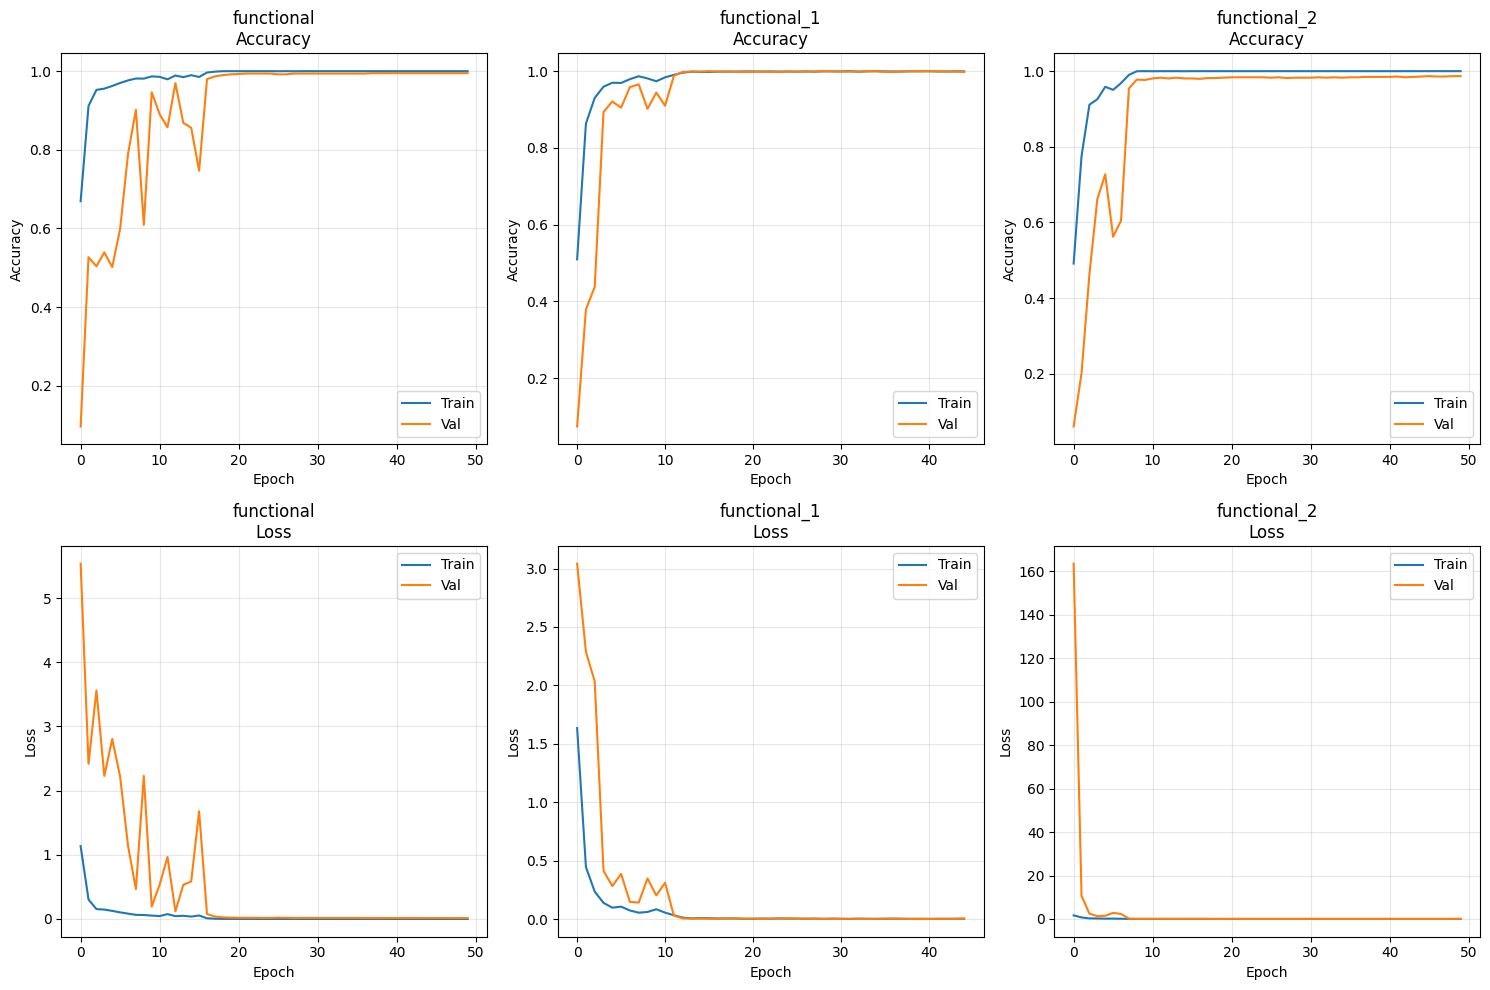

In [26]:
def plot_training_history(histories, models):
    num_models = len(histories)
    fig, axes = plt.subplots(2, num_models, figsize=(5 * num_models, 10))

    for i, (hist, model) in enumerate(zip(histories, models)):
        # Plot Accuracy
        axes[0, i].plot(hist.history['accuracy'], label='Train')
        axes[0, i].plot(hist.history['val_accuracy'], label='Val')
        axes[0, i].set_title(f'{model.name}\nAccuracy')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Accuracy')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Plot Loss
        axes[1, i].plot(hist.history['loss'], label='Train')
        axes[1, i].plot(hist.history['val_loss'], label='Val')
        axes[1, i].set_title(f'{model.name}\nLoss')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Loss')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(histories, models)

# 4. Model Evaluation
We evaluate each model individually on the test set using various metrics: Accuracy, Precision, Recall, and F1-Score.

## 4.1 Individual Model Evaluation

In [14]:
# Load Trained Models
inception_v3_model = load_model('models/non-augmented/model_1.h5')
efficientnet_b2_model = load_model('models/non-augmented/model_2.h5')
resnet_101v2_model = load_model('models/non-augmented/model_3.h5')

In [15]:
models = [inception_v3_model, efficientnet_b2_model, resnet_101v2_model]


==================== EVALUATING: functional ====================
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step

Overall Accuracy: 0.9990
Weighted Precision: 0.9990
Weighted Recall: 0.9990
Weighted F1-Score: 0.9990


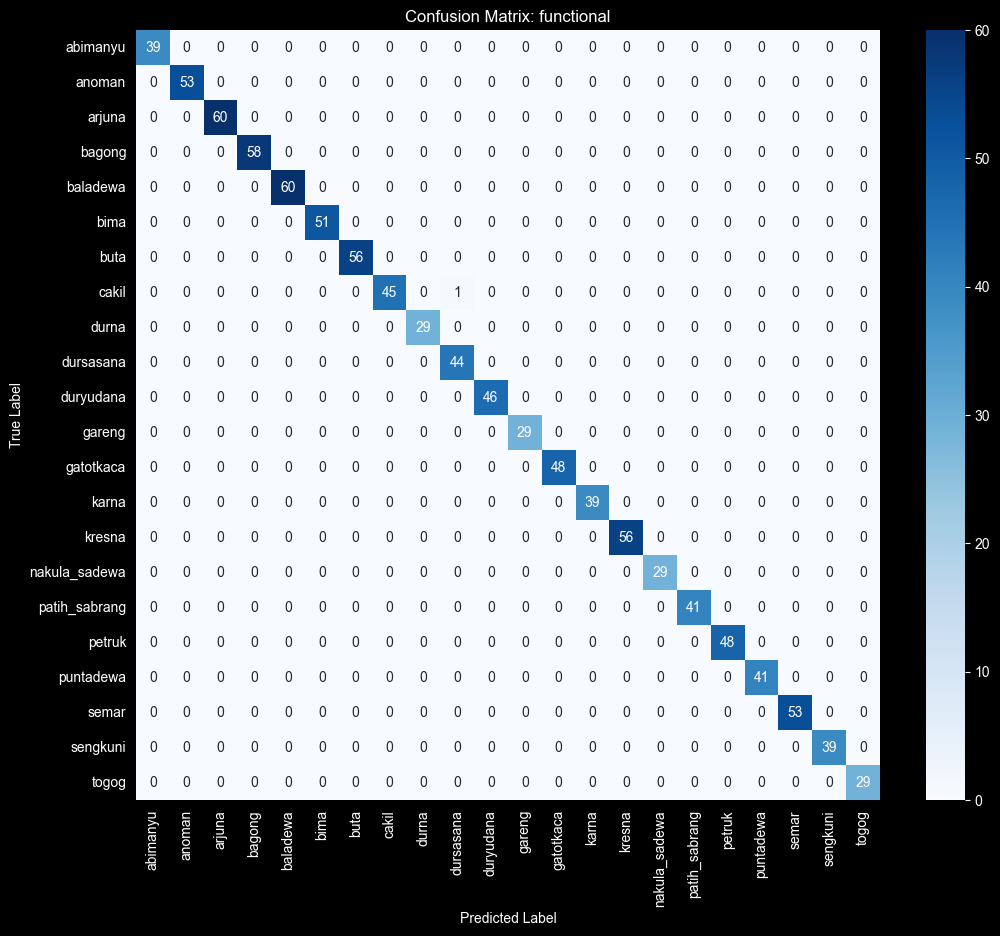

------------------------------------------------------------

==================== EVALUATING: functional_1 ====================
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step

Overall Accuracy: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Weighted F1-Score: 1.0000


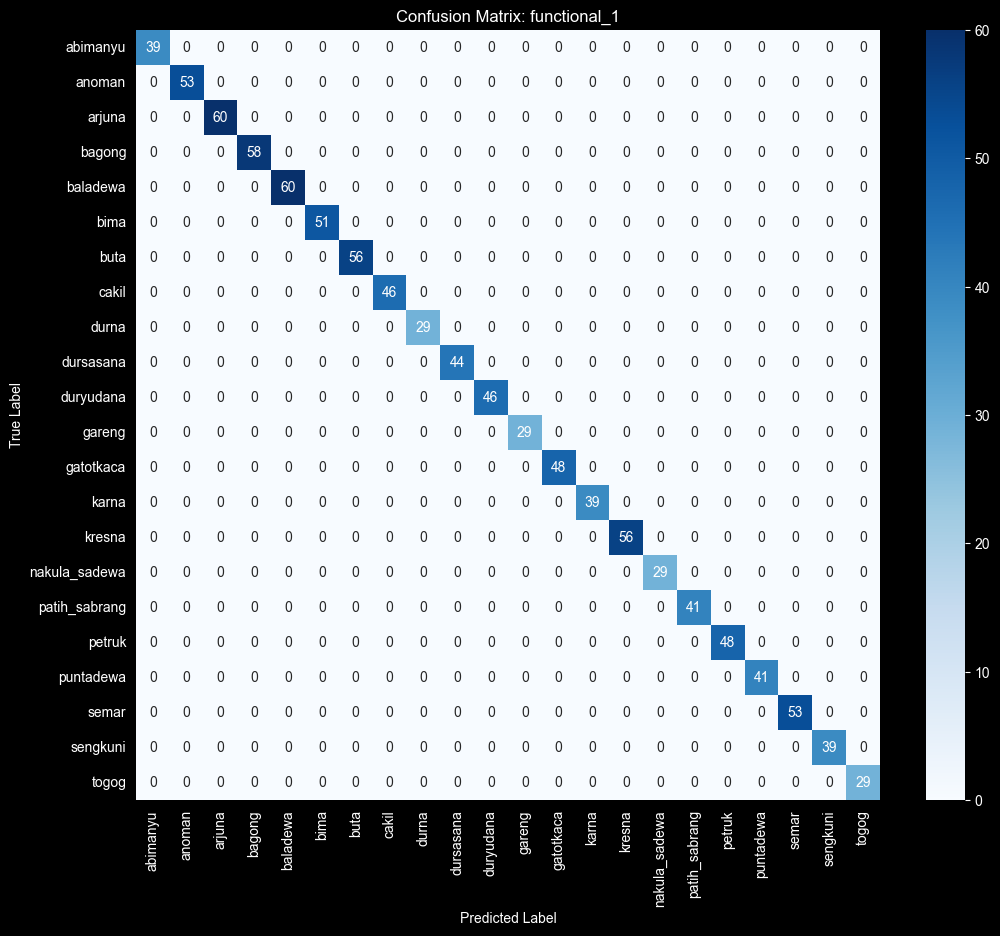

------------------------------------------------------------

==================== EVALUATING: functional_2 ====================
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step

Overall Accuracy: 0.9950
Weighted Precision: 0.9951
Weighted Recall: 0.9950
Weighted F1-Score: 0.9950


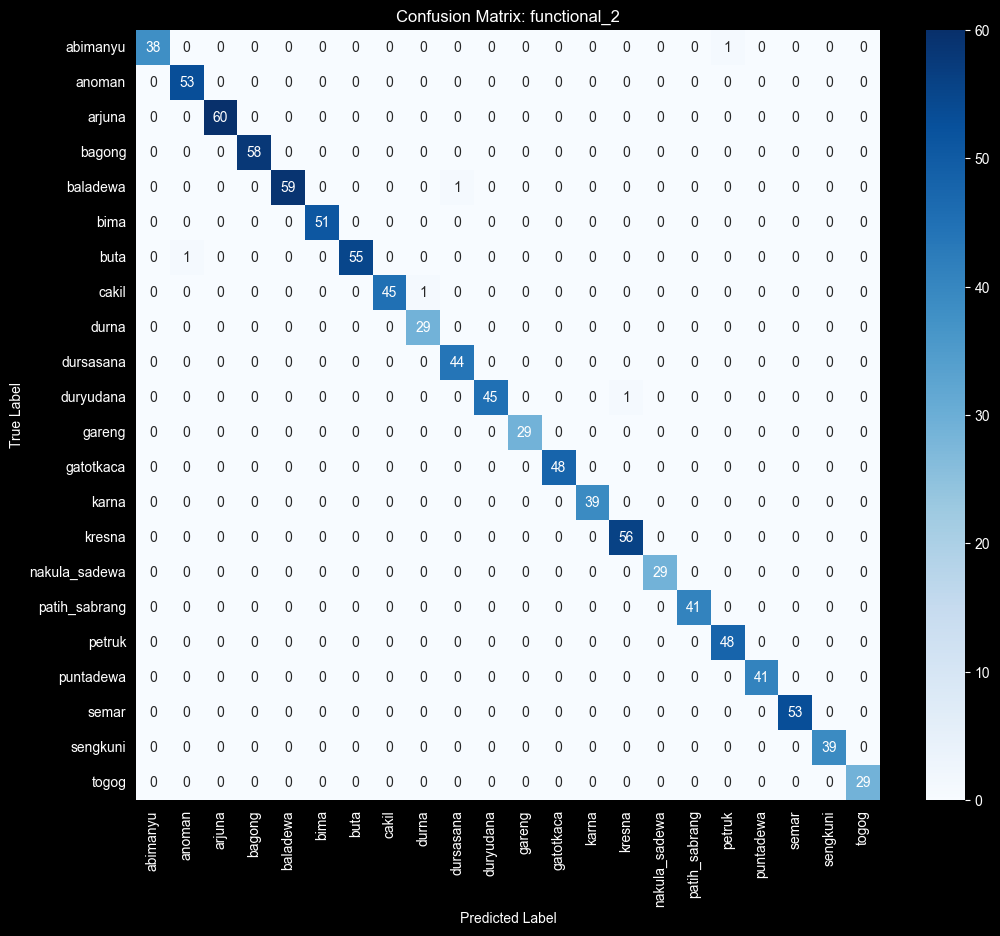

------------------------------------------------------------


In [16]:
# Prepare test data
test_generator.reset()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate each model
for i, model in enumerate(models):
    print(f"\n{'='*20} EVALUATING: {model.name} {'='*20}")

    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")
    print(f"Weighted Precision: {report['weighted avg']['precision']:.4f}")
    print(f"Weighted Recall: {report['weighted avg']['recall']:.4f}")
    print(f"Weighted F1-Score: {report['weighted avg']['f1-score']:.4f}")

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix: {model.name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("-" * 60)

## 4.2 Ensemble Majority Voting
We combine the predictions of all three models. For each image, the final class is chosen based on the majority vote among the models.


==================== ENSEMBLE PERFORMANCE ====================

Ensemble Accuracy: 1.0000
Ensemble Precision: 1.0000
Ensemble Recall: 1.0000
Ensemble F1-Score: 1.0000


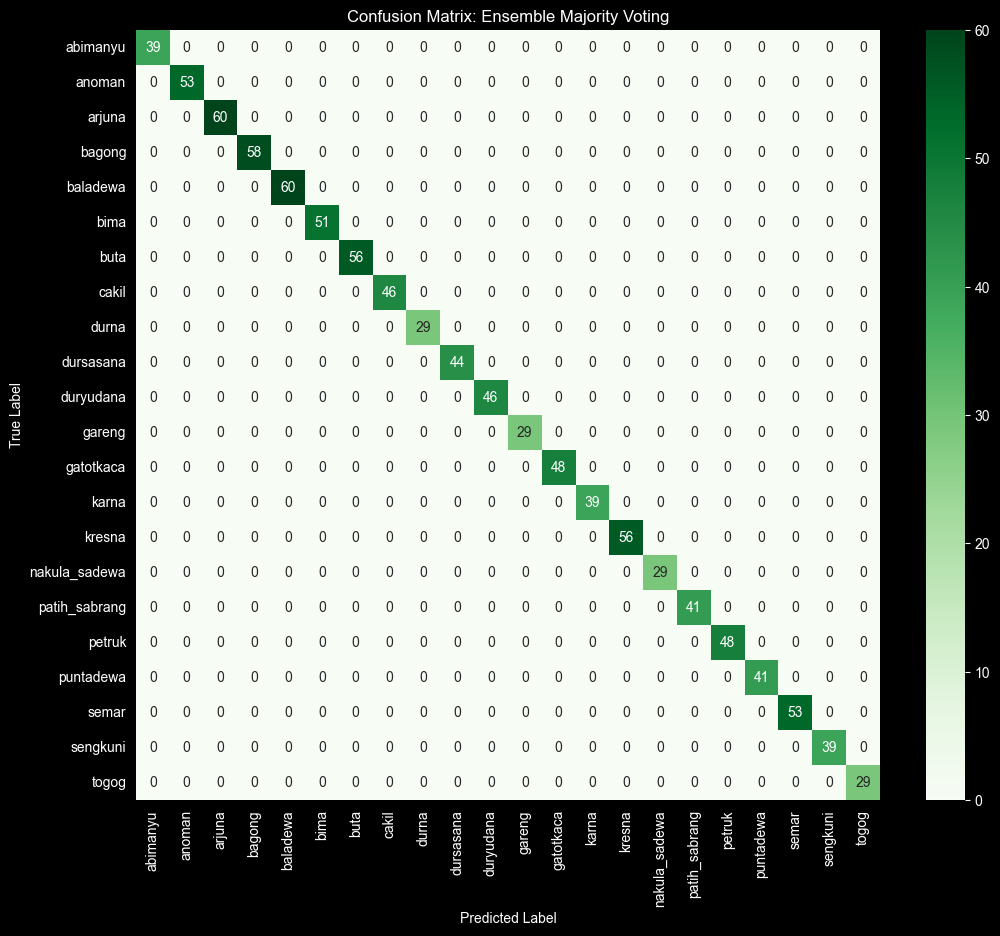

In [17]:
# Collect predictions from all models
all_model_preds = []
for model in models:
    test_generator.reset()
    preds = model.predict(test_generator, verbose=0)
    all_model_preds.append(np.argmax(preds, axis=1))

# Apply Majority Voting
stacked_preds = np.array(all_model_preds)
ensemble_preds, _ = mode(stacked_preds, axis=0)
ensemble_preds = ensemble_preds.flatten() # Ensure 1D array

print("\n" + "="*20 + " ENSEMBLE PERFORMANCE " + "="*20)

# Evaluate Ensemble
ensemble_report = classification_report(y_true, ensemble_preds, target_names=class_labels, output_dict=True)

print(f"\nEnsemble Accuracy: {ensemble_report['accuracy']:.4f}")
print(f"Ensemble Precision: {ensemble_report['weighted avg']['precision']:.4f}")
print(f"Ensemble Recall: {ensemble_report['weighted avg']['recall']:.4f}")
print(f"Ensemble F1-Score: {ensemble_report['weighted avg']['f1-score']:.4f}")

# Ensemble Confusion Matrix
ensemble_cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix: Ensemble Majority Voting')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()